In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import functions as f
from pyspark.sql.functions import col
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

spark = SparkSession.builder.appName('ABC').getOrCreate();

In [7]:
df_ec = spark.read.option('inferSchema','true').csv('EC*',header = True)
df_aval = spark.read.option('inferSchema','true').csv('AVAL*',header = True)
df_avh = spark.read.option('inferSchema','true').csv('AVH*',header = True)

In [30]:
df_ec.printSchema();
df_aval.printSchema();
df_avh.printSchema();

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)



/home/droro/Documents/Python Proyectos/BigData-Scripts/Taller Ventanas/env/local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


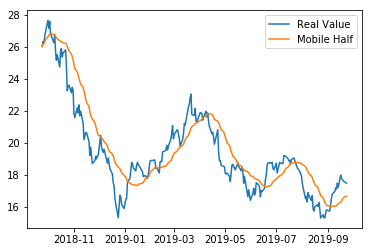

In [8]:

window1 = Window.orderBy(df_ec.Date).rowsBetween(-20,0)
df17 = df_ec.select('Date', f.avg('Close').over(window1).alias('Average'))
fig, ax = plt.subplots()
EC_pd = df_ec.toPandas()
EC_AVG = df17.toPandas()
EC_pd.set_index("Date")
EC_AVG.set_index("Date")
ax.plot(EC_pd.Date, EC_pd.Close, label="Real Value")
ax.plot(EC_AVG.Date, EC_AVG.Average, label="Mobile Half")
ax.legend()







In [42]:
from pyspark.sql import Window
window = Window.orderBy(df_ec.Date.asc());

df = df_ec.select('Date','Close',f.lag('Close').over(window).alias('prev_close'));

df_total = df_ec.select(f.lit('EC').alias('Company'),'Date','Close').union(df_aval.select(f.lit('AVAL').alias('Company'),'Date','Close'));

df_total.groupBy("Company").count().show(5);

+-------+-----+
|Company|count|
+-------+-----+
|   AVAL|  252|
|     EC|  252|
+-------+-----+



In [44]:
window2 = Window.partitionBy('Company').orderBy(df_total.Date.asc());


In [49]:
df_total.select ('Company','Date',f.lag('Date').over(window2).alias('prev')).where("Company = 'EC' ").show(10);

+-------+----------+----------+
|Company|      Date|      prev|
+-------+----------+----------+
|     EC|2018-09-25|      null|
|     EC|2018-09-26|2018-09-25|
|     EC|2018-09-27|2018-09-26|
|     EC|2018-09-28|2018-09-27|
|     EC|2018-10-01|2018-09-28|
|     EC|2018-10-02|2018-10-01|
|     EC|2018-10-03|2018-10-02|
|     EC|2018-10-04|2018-10-03|
|     EC|2018-10-05|2018-10-04|
|     EC|2018-10-08|2018-10-05|
+-------+----------+----------+
only showing top 10 rows



In [52]:
df_total.select ('Company','Date','Close',f.avg('Close').over(window2).alias('avg')).show(10);

+-------+----------+--------+-----------------+
|Company|      Date|   Close|              avg|
+-------+----------+--------+-----------------+
|   AVAL|2018-09-25|7.620000|             7.62|
|   AVAL|2018-09-26|7.650000|            7.635|
|   AVAL|2018-09-27|7.850000|7.706666666666666|
|   AVAL|2018-09-28|7.760000|7.719999999999999|
|   AVAL|2018-10-01|7.700000|7.715999999999999|
|   AVAL|2018-10-02|7.700000|7.713333333333334|
|   AVAL|2018-10-03|7.690000|             7.71|
|   AVAL|2018-10-04|7.660000|7.703749999999999|
|   AVAL|2018-10-05|7.620000|7.694444444444445|
|   AVAL|2018-10-08|7.590000|            7.684|
+-------+----------+--------+-----------------+
only showing top 10 rows



In [55]:
window3 = Window.orderBy(df_ec.Date.asc()).rowsBetween(-5,0);
df_ec.select('Date',f.collect_list('Date').over(window3).alias('dates'),f.avg("Close").over(window3).alias('prom_closer')).show(20);

+----------+--------------------+------------------+
|      Date|               dates|       prom_closer|
+----------+--------------------+------------------+
|2018-09-25|        [2018-09-25]|             26.32|
|2018-09-26|[2018-09-25, 2018...|        26.2699995|
|2018-09-27|[2018-09-25, 2018...|26.383333333333336|
|2018-09-28|[2018-09-25, 2018...|26.520000000000003|
|2018-10-01|[2018-09-25, 2018...|26.746000000000002|
|2018-10-02|[2018-09-25, 2018...|        26.8116665|
|2018-10-03|[2018-09-26, 2018...|        27.0216665|
|2018-10-04|[2018-09-27, 2018...|        27.1283335|
|2018-10-05|[2018-09-28, 2018...|27.136666666666667|
|2018-10-08|[2018-10-01, 2018...|27.021666666666665|
|2018-10-09|[2018-10-02, 2018...|             26.87|
|2018-10-10|[2018-10-03, 2018...|26.628333666666663|
|2018-10-11|[2018-10-04, 2018...|26.223333666666665|
|2018-10-12|[2018-10-05, 2018...|25.996666833333332|
|2018-10-15|[2018-10-08, 2018...|25.675000166666663|
|2018-10-16|[2018-10-09, 2018...|25.5883333333